# Digit Classifier Project

this notebook shows some of the visualisations done for the digit classification project <br> dataset: MNIST handwritten digit dataset

In [2]:
from model import CNN, ANN
from get_data import load_data
import torch
import torchvision.transforms as transforms
import torchvision.datasets as dsets
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import os
from PIL import Image
from sklearn.manifold import TSNE

%matplotlib inline  
torch.manual_seed(42)
np.random.seed(42)

In [3]:
train_dset = dsets.MNIST(
        root = "./data",
        train = True,
        transform = transforms.ToTensor(),
        download = True
    )

test_dset = dsets.MNIST(
    root = "./data",
    train = False,
    transform = transforms.ToTensor()
)

In [4]:
print(len(train_dset))
print(len(test_dset))

60000
10000


In [5]:
first_image, first_label = train_dset[0]
print(first_image.shape)
print(f"First label: {first_label}")

torch.Size([1, 28, 28])
First label: 5


## Visualise distribution of labels in both training and testing datasets

In [6]:
from collections import Counter

num_train_labels = Counter([label for _, label in train_dset])
num_test_labels = Counter([label for _, label in test_dset])

In [7]:
num_train_labels

Counter({1: 6742,
         7: 6265,
         3: 6131,
         2: 5958,
         9: 5949,
         0: 5923,
         6: 5918,
         8: 5851,
         4: 5842,
         5: 5421})

In [8]:
num_test_labels

Counter({1: 1135,
         2: 1032,
         7: 1028,
         3: 1010,
         9: 1009,
         4: 982,
         0: 980,
         8: 974,
         6: 958,
         5: 892})

Text(0, 0.5, 'Count')

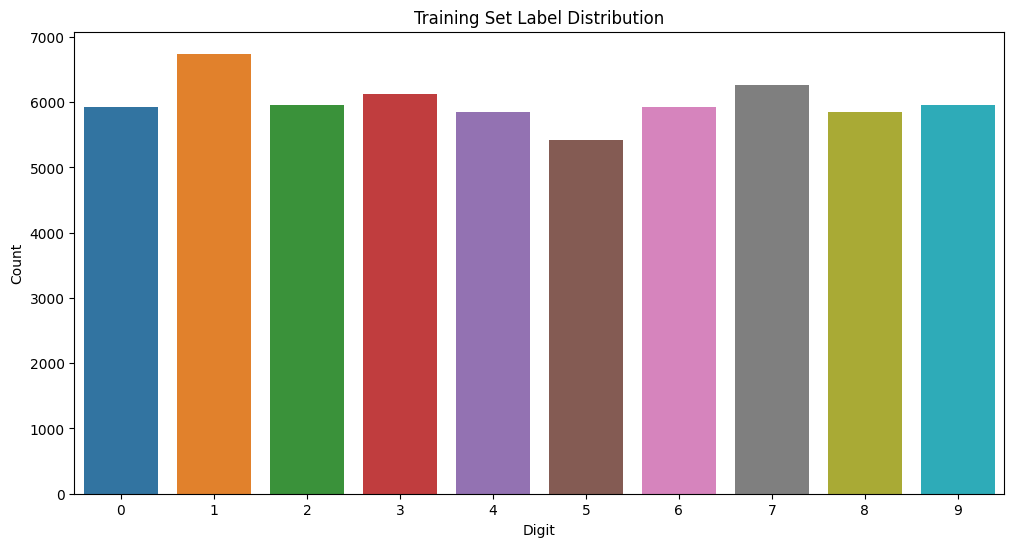

In [9]:
plt.figure(figsize=(12,6))
sns.barplot(x=list(num_train_labels.keys()), y=list(num_train_labels.values()))
plt.title("Training Set Label Distribution")
plt.xlabel("Digit")
plt.ylabel("Count")


Text(0, 0.5, 'Count')

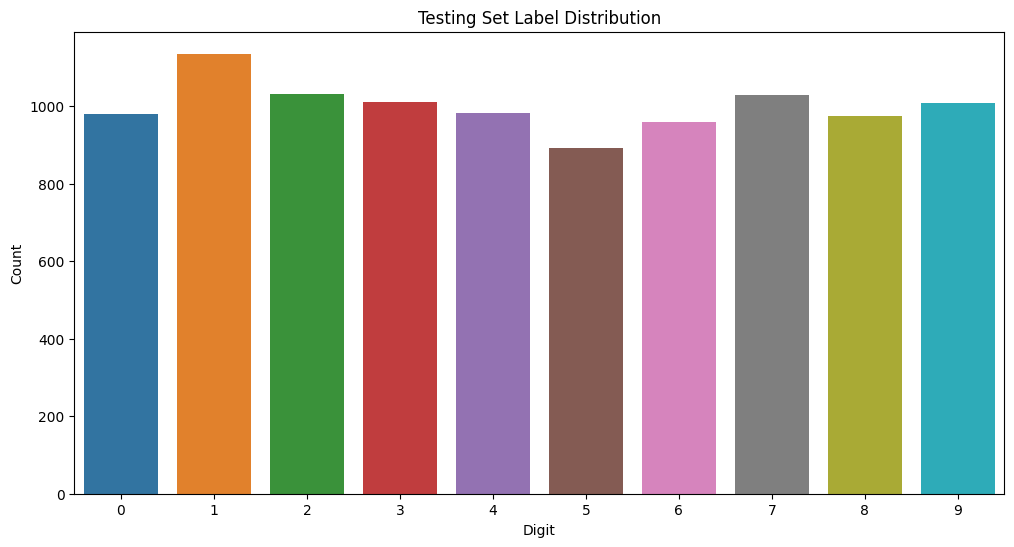

In [10]:
plt.figure(figsize=(12,6))
sns.barplot(x=list(num_test_labels.keys()), y=list(num_test_labels.values()))
plt.title("Testing Set Label Distribution")
plt.xlabel("Digit")
plt.ylabel("Count")

Both training and testing dataset seems to be balanced.

## Visualise how well the different digit classes are seperated

In [11]:
from torch.utils.data import Subset
# prepare subset for t-SNE visualisation

def get_tsne_subset(dataset, num_samples):
    # Randomly select 'num_samples' unique indices from the dataset
    subset_indicies = np.random.choice(len(dataset), size = num_samples, replace=False)

    # Create a subset of the dataset using the selected indices
    train_subset = Subset(train_dset, subset_indicies)

    # Stack images to create the tensor for X_subset, extract labels into a numpy array
    X_subset = torch.stack([train_subset[i][0] for i in range(num_samples)])
    y_subset = np.array([train_subset[i][1] for i in range(num_samples)])

    # Flatten each image into a 1D vector
    X_subset = X_subset.view(num_samples, -1).numpy()
    
    return X_subset, y_subset

In [12]:
num_samples = 5000
X_subset, y_subset = get_tsne_subset(train_dset, num_samples=num_samples)

In [13]:
X_subset.shape

(5000, 784)

In [14]:
y_subset.shape

(5000,)

In [15]:
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_tsne = tsne.fit_transform(X_subset)

In [16]:
import matplotlib.colors as mcolors

colors = plt.cm.tab10(np.linspace(0,1,10))
cmap = mcolors.ListedColormap(colors)

In [17]:
def plot_tsne(X_tsne, y_subset, num_samples, cmap):
    plt.figure(figsize=(10, 8))

    # plot t-SNE vectors as a scatter plot
    scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_subset, cmap=cmap, alpha=0.4)
    plt.colorbar(scatter, label="Digit")
    plt.title(f"t-SNE Visualization of MNIST Training Data ({num_samples} samples)")
    plt.xlabel("t-SNE dimension 1")
    plt.ylabel("t-SNE dimension 2")

    # Label the centre of each digit cluster on the plot
    for digit in np.unique(y_subset):
        # Get a boolean array that indicates if the samples belong to current digit 
        indices = y_subset == digit
        # get all the vectors for the indicies in y_subset that are the same as current digit
        # average those vectors up to find the coordinates of the centre. 
        centroid = np.mean(X_tsne[indices], axis=0)
        
        # Annotate the centroid with the digit label
        plt.text(centroid[0], centroid[1], str(digit), fontsize=10, ha='center', va='center', 
                bbox=dict(facecolor='white', alpha=0.5, edgecolor='none'))
    plt.show()

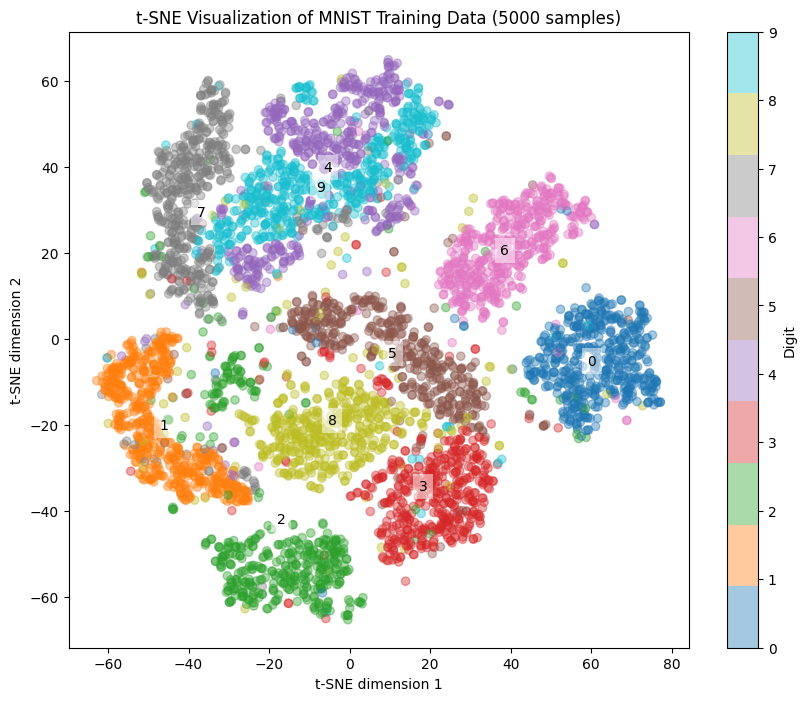

In [18]:
plot_tsne(X_tsne, y_subset, num_samples, cmap)

The t-SNE plot shows clear clusters for MNIST digits, showing clear feature seperation. Most of the digits have well-defined regions, however digits 9 , 4 and 7 seem to overlap, we can also see digits 3 and 5 have small overlap. These overlaps could result in potential misclassification in our models predictions.

try create a t-SNE visualisation with more samples ~10,000


In [19]:
num_samples = 10000
X_subset2, y_subset2 = get_tsne_subset(train_dset,num_samples = num_samples)

In [20]:
X_subset2.shape

(10000, 784)

In [21]:
y_subset2.shape

(10000,)

In [22]:
X_tsne2 = tsne.fit_transform(X_subset2)

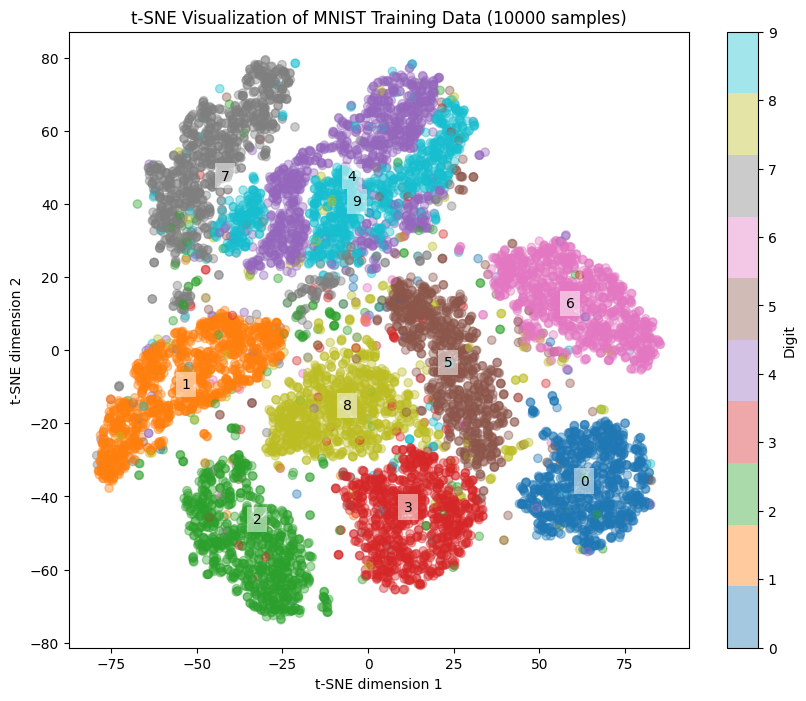

In [23]:
plot_tsne(X_tsne2, y_subset2, num_samples, cmap)

From the t-SNE plot with 10,000 samples , we can see more distinct seperation between digits besides for digits 4 and 9 which still seem to be overlapping. We can also see that some datapoints for digit 8 is overlapping with digit 5.

## Visualise samples from training data

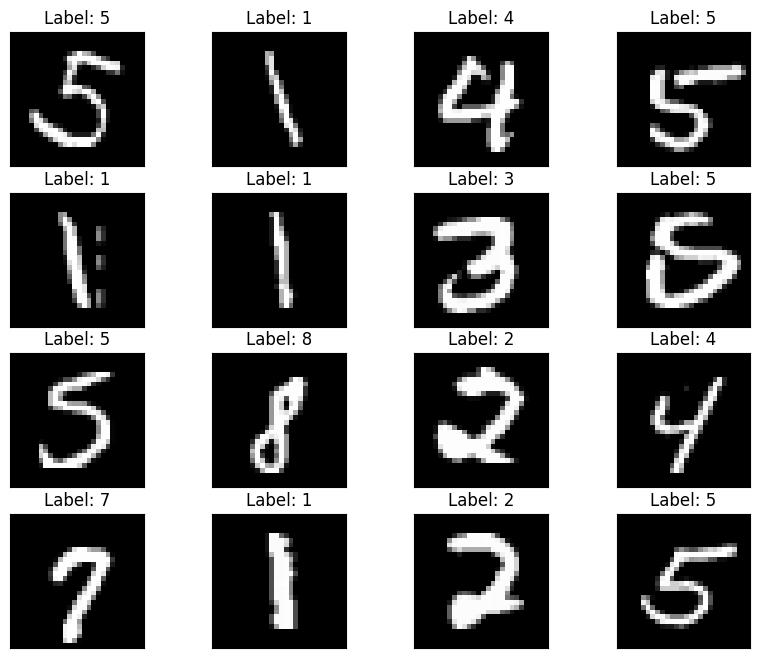

In [24]:
train_loader, val_loader, test_loader = load_data(batch_size=100)
train_images, train_labels = next(iter(train_loader))
plt.figure(figsize=(10, 8))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i].squeeze(0), cmap='gray')  # Use squeeze() to remove the channel dimension
    plt.title(f"Label: {train_labels[i]}")

## Visualise samples from the validation data

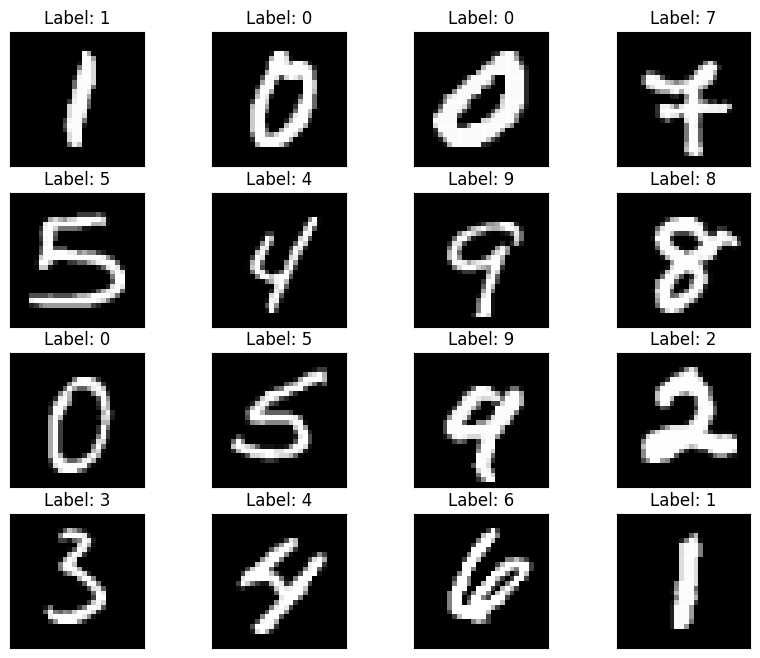

In [26]:
val_images, val_labels = next(iter(val_loader))
plt.figure(figsize=(10, 8))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(val_images[i].squeeze(0), cmap='gray')  # Use squeeze() to remove the channel dimension
    plt.title(f"Label: {val_labels[i]}")

## Visualise samples from test data

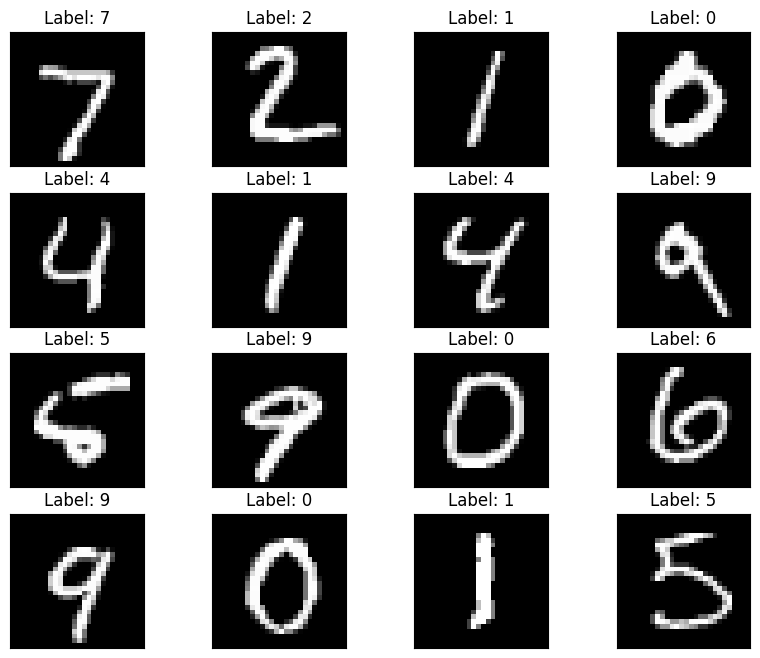

In [27]:
test_images, test_labels = next(iter(test_loader))
plt.figure(figsize=(10, 8))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[i].squeeze(0), cmap='gray')  # Use squeeze() to remove the channel dimension
    plt.title(f"Label: {test_labels[i]}")

## Test the model on unseen data

In [28]:
img_names = os.listdir("unseen_data")
imgs = [np.array(Image.open(os.path.join("unseen_data", img_name))) for img_name in img_names]

Visualise the images in the unseen data folder

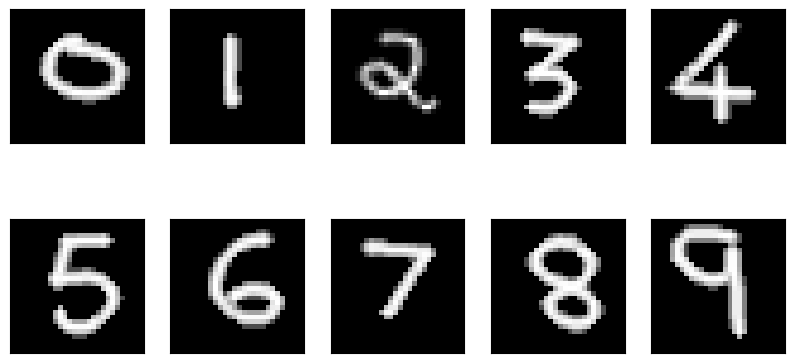

In [29]:
plt.figure(figsize=(10,5))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(imgs[i], aspect=1, cmap='gray')

use our trained model to try predict on these images

In [30]:
print(torch.from_numpy(imgs[0]))


tensor([[ 23,  23,  23,  23,  23,  23,  23,  23,  23,  23,  23,  23,  23,  23,
          23,  23,  23,  23,  23,  23,  23,  23,  23,  23,  23,  23,  23,  23],
        [ 23,  23,  23,  23,  23,  23,  23,  23,  23,  23,  23,  23,  23,  23,
          23,  23,  23,  23,  23,  23,  23,  23,  23,  23,  23,  23,  23,  23],
        [ 23,  23,  23,  23,  23,  23,  23,  23,  23,  23,  23,  23,  23,  23,
          23,  23,  23,  23,  23,  23,  23,  23,  23,  23,  23,  23,  23,  23],
        [ 23,  23,  23,  23,  23,  23,  23,  23,  23,  23,  23,  23,  23,  23,
          23,  23,  23,  23,  23,  23,  23,  23,  23,  23,  23,  23,  23,  23],
        [ 23,  23,  23,  23,  23,  23,  23,  23,  23,  23,  23,  23,  23,  23,
          23,  23,  23,  23,  23,  23,  23,  23,  23,  23,  23,  23,  23,  23],
        [ 23,  23,  23,  23,  23,  23,  23,  23,  23,  23,  23, 139, 171, 188,
         171,  23,  23,  23,  23,  23,  23,  23,  23,  23,  23,  23,  23,  23],
        [ 23,  23,  23,  23,  23,  23,  23,  2

In [31]:
imgs_tensor = torch.tensor(np.array(imgs), dtype=torch.float32)
imgs_tensor /= 255.0
imgs_tensor = imgs_tensor.unsqueeze(1)

check image tensor after preprocessing

In [32]:
imgs_tensor

tensor([[[[0.0902, 0.0902, 0.0902,  ..., 0.0902, 0.0902, 0.0902],
          [0.0902, 0.0902, 0.0902,  ..., 0.0902, 0.0902, 0.0902],
          [0.0902, 0.0902, 0.0902,  ..., 0.0902, 0.0902, 0.0902],
          ...,
          [0.0902, 0.0902, 0.0902,  ..., 0.0902, 0.0902, 0.0902],
          [0.0902, 0.0902, 0.0902,  ..., 0.0902, 0.0902, 0.0902],
          [0.0902, 0.0902, 0.0902,  ..., 0.0902, 0.0902, 0.0902]]],


        [[[0.0902, 0.0902, 0.0902,  ..., 0.0902, 0.0902, 0.0902],
          [0.0902, 0.0902, 0.0902,  ..., 0.0902, 0.0902, 0.0902],
          [0.0902, 0.0902, 0.0902,  ..., 0.0902, 0.0902, 0.0902],
          ...,
          [0.0902, 0.0902, 0.0902,  ..., 0.0902, 0.0902, 0.0902],
          [0.0902, 0.0902, 0.0902,  ..., 0.0902, 0.0902, 0.0902],
          [0.0902, 0.0902, 0.0902,  ..., 0.0902, 0.0902, 0.0902]]],


        [[[0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
          [0.0000, 0.0000, 0.0000,  ..

In [33]:
from utils import load_model, predict_digit

# test on CNN model
model = CNN(num_class = 10)
model = load_model(model, "model/cnn_model.pth")

In [34]:
imgs_tensor.shape

torch.Size([10, 1, 28, 28])

In [35]:
import torch.nn.functional as F


# create a function that predicts all the unseen image data
def predict(model, img_tensor):
    with torch.no_grad():
        logits = model(img_tensor)
        probabilities = F.softmax(logits, dim=1)
        _ , preds = torch.max(probabilities, 1)
        return preds.item()

In [36]:
predictions = []
for img in imgs_tensor:
    img = img.unsqueeze(0)
    prediction = predict(model, img)
    predictions.append(prediction)

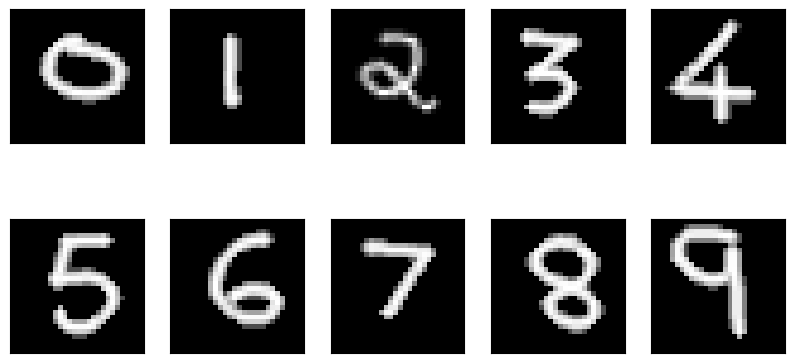

In [37]:
plt.figure(figsize=(10,5))
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(imgs[i], aspect=1, cmap='gray')

In [38]:
predictions

[0, 1, 2, 3, 4, 5, 6, 3, 8, 7]

As we can see the model got 8 out of 10 digits correct

In [39]:
# test using ANN model
model2 = ANN(28*28, 10)
model2 = load_model(model2,"model/ann_model.pth")

In [40]:
predictions = []
for img in imgs_tensor:
    img = img.unsqueeze(0)
    prediction = predict(model2, img)
    predictions.append(prediction)

In [41]:
predictions

[9, 1, 2, 3, 5, 5, 6, 2, 8, 8]

We can see that the ANN model got 6 out of 10 digits correct, threrefore the CNN model outperformed the ANN model on unseen image data. This is expected as CNN is better suited for image classification task